##### 为了对导数的这种解释进行可视化，我们将使用matplotlib， 这是一个Python中流行的绘图库。 要配置matplotlib生成图形的属性，我们需要定义几个函数。 在下面，use_svg_display函数指定matplotlib软件包输出svg图表以获得更清晰的图像。

##### 注释#@save是一个特殊的标记，会将对应的函数、类或语句保存在d2l包中。 因此，以后无须重新定义就可以直接调用它们

In [9]:
import scipy
print(scipy.__version__)

1.10.1


In [2]:
import numpy as np
from matplotlib_inline import backend_inline
from d2l import torch as d2l

In [3]:
def use_svg_display():  #@save
    """使用svg格式绘图"""
    backend_inline.set_matplotlib_formats('svg')

##### 定义set_figsize函数来设置图表大小。 注意，这里可以直接使用d2l.plt

In [4]:
def set_figsize(figsize=(3.5, 2.5)):  #@save
    """设置matplotlib的图表大小"""
    use_svg_display()
    d2l.plt.rcParams['figure.figsize'] = figsize

##### 下面的set_axes函数用于设置由matplotlib生成图表的轴的属性

In [5]:
#@save
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """设置matplotlib的轴"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

##### 通过这三个用于图形配置的函数，定义一个plot函数来简洁地绘制多条曲线， 因为我们需要在整个书中可视化许多曲线

In [6]:
#@save
def plot(X, Y=None, xlabel=None, ylabel=None, legend=None, xlim=None,
         ylim=None, xscale='linear', yscale='linear',
         fmts=('-', 'm--', 'g-.', 'r:'), figsize=(3.5, 2.5), axes=None):
    """绘制数据点"""
    if legend is None:
        legend = []

    set_figsize(figsize)
    axes = axes if axes else d2l.plt.gca()

    # 如果X有一个轴，输出True
    def has_one_axis(X):
        return (hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list)
                and not hasattr(X[0], "__len__"))

    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)
    axes.cla()
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt)
        else:
            axes.plot(y, fmt)
    set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)

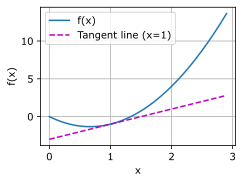

In [7]:
def f(x):
    return 3 * x ** 2 - 4 * x
x = np.arange(0, 3, 0.1)
plot(x, [f(x), 2 * x - 3], 'x', 'f(x)', legend=['f(x)', 'Tangent line (x=1)'])

##### 求导是几乎所有深度学习优化算法的关键步骤。深度学习框架通过自动计算导数，即自动微分（automatic differentiation）来加快求导

In [10]:
import torch
x = torch.arange(4.0)
x

tensor([0., 1., 2., 3.])

In [11]:
x.requires_grad_(True)  # 等价于x=torch.arange(4.0,requires_grad=True)
x.grad  # 默认值是None

In [12]:
y = 2 * torch.dot(x, x)
y

tensor(28., grad_fn=<MulBackward0>)

##### 通过调用反向传播函数来自动计算y关于x每个分量的梯度

##### 在 PyTorch 中，只要一个张量 y 是由带梯度的张量（如 x.requires_grad=True）通过运算得到的，PyTorch 就会为它构建“计算图（Computational Graph）”，于是 y 就会自动拥有 backward() 方法。

In [13]:
y.backward()
x.grad

tensor([ 0.,  4.,  8., 12.])

In [14]:
# 在默认情况下，PyTorch会累积梯度，我们需要清除之前的值
x.grad.zero_()
y = x.sum()
y.backward()
x.grad

tensor([1., 1., 1., 1.])

In [17]:
# 对非标量调用backward需要传入一个gradient参数，该参数指定微分函数关于self的梯度。
# 本例只想求偏导数的和，所以传递一个1的梯度是合适的
x.grad.zero_()
y = x * x
# 等价于y.backward(torch.ones(len(x)))
y.sum().backward()
x,y,x.grad

(tensor([0., 1., 2., 3.], requires_grad=True),
 tensor([0., 1., 4., 9.], grad_fn=<MulBackward0>),
 tensor([0., 2., 4., 6.]))

##### 有时，我们希望将某些计算移动到记录的计算图之外.这里可以分离y来返回一个新变量u，该变量与y具有相同的值， 但丢弃计算图中如何计算y的任何信息。 换句话说，梯度不会向后流经u到x。因此，下面的反向传播函数计算z=u*x关于x的偏导数，同时将u作为常数处理， 而不是z=x*x*x关于x的偏导数。

In [18]:
x.grad.zero_()
y = x * x
u = y.detach()
z = u * x

z.sum().backward()
x.grad == u

tensor([True, True, True, True])

##### 使用自动微分的一个好处是： 即使构建函数的计算图需要通过Python控制流（例如，条件、循环或任意函数调用），我们仍然可以计算得到的变量的梯度。 在下面的代码中，while循环的迭代次数和if语句的结果都取决于输入a的值。

In [20]:
def f(a):
    b = a * 2
    while b.norm() < 1000:
        b = b * 2
    if b.sum() > 0:
        c = b
    else:
        c = 100 * b
    return c

In [22]:
a = torch.randn(size=(), requires_grad=True)
d = f(a)
d.backward()

In [24]:
a.grad == d / a

tensor(True)